# Welcome to FIX!
In this notebook, we give some examples of **loading dataset** and **running benchmarks**. The organization is as follows:
* Part 1: How to load each dataset
* Part 2: How to run some baseline expert-feature methods
* Part 3: How to compute FIX scores at scale

# Part 1: Loading Datasets

We'll first talk about how to load the datasets described in our paper.
FIX is built using the `exlib` library, which you can install using `pip install exlib`.

In [2]:
# !pip install exlib
import sys
sys.path.append('../src')
import exlib
import torch
import torch.nn.functional as F
import torchvision
import datasets as huggingface_datasets # Not to be confused with exlib.datasets!
import matplotlib.pyplot as plt
import numpy as np

## Cholecystectomy Dataset

This dataset contains image data from cholecystectomy surgery (gallbladder removal). The fields are as follows:

* `image`: A view of the surgery.
* `gonogo`: Whether it is safe or unsafe to operate. Background (0), safe (1), and unsafe (2).
* `organs`: Relevant organ structures for surgery. Background (0), liver (1), gallbladder (2), and hepatocystic triangle (3). These are the expert-specified interpretable features.

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/cholecystectomy).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/cholec.ipynb).

In [3]:
from exlib.datasets.cholec import CholecDataset
cholec_dataset = CholecDataset(split="test")
cholec_item = cholec_dataset[0]
cholec_image = cholec_item["image"]
cholec_gonogo = cholec_item["gonogo"]
cholec_organs = cholec_item["organs"]

print("image:", cholec_image.shape, cholec_image.dtype)
print("gonogo:", cholec_gonogo.shape, cholec_gonogo.dtype)
print("organs:", cholec_organs.shape, cholec_organs.dtype)

Generating train split:   0%|          | 0/812 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/203 [00:00<?, ? examples/s]

image: torch.Size([3, 360, 640]) torch.float32
gonogo: torch.Size([360, 640]) torch.int64
organs: torch.Size([360, 640]) torch.int64


Text(0.5, 1.0, 'Back (0), Liver (1), Gallb. (2), Hept. (3)')

<Figure size 640x480 with 0 Axes>

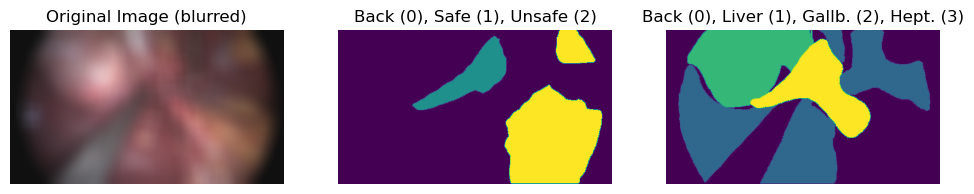

In [4]:
plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i in range(3): ax[i].set_axis_off()

cholec_image = torchvision.transforms.GaussianBlur(41, (50.0, 50.0))(cholec_image)

ax[0].imshow(cholec_image.numpy().transpose(1,2,0))
ax[1].imshow(cholec_gonogo.numpy())
ax[2].imshow(cholec_organs.numpy())

ax[0].set_title("Original Image (blurred)")
ax[1].set_title("Back (0), Safe (1), Unsafe (2)")
ax[2].set_title("Back (0), Liver (1), Gallb. (2), Hept. (3)")

## Chest X-ray Dataset

This dataset contains vision data for chest X-ray pathology identification.
The fields are as follows:

* `image`: The image of the chest X-ray.
* `pathols`: A binary vector that denotes which of the 14 pathologies are present.
* `struct`: A collection of binary masks over the image for the relevant anatomical structures. These are the expert-specified interpretable features.

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/chestx).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/chestx.ipynb).

In [5]:
from exlib.datasets.chestx import ChestXDataset
chestx_dataset = ChestXDataset(split="test")

# Find an image that has at least 2 pathologies present
for i in range(10000):
    chestx_item = chestx_dataset[i]
    if chestx_item["pathols"].sum() > 1: break

chestx_image = chestx_item["image"]
chestx_pathols = chestx_item["pathols"]
chestx_structs = chestx_item["structs"]

print("image:", chestx_image.shape, chestx_image.dtype)
print("pathols:", chestx_pathols.shape, chestx_pathols.dtype)
print("structs:", chestx_structs.shape, chestx_structs.dtype)

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/23094 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5774 [00:00<?, ? examples/s]

image: torch.Size([1, 224, 224]) torch.float32
pathols: torch.Size([14]) torch.int64
structs: torch.Size([14, 224, 224]) torch.int64


In [6]:
print("All pathologies:")
print(", ".join([f"({i}) {s}" for i,s in enumerate(chestx_dataset.pathology_names)]))

print("\nAll structures:")
print(", ".join([f"({i}) {s}" for i,s in enumerate(chestx_dataset.structure_names)]))

All pathologies:
(0) Atelectasis, (1) Cardiomegaly, (2) Consolidation, (3) Edema, (4) Effusion, (5) Emphysema, (6) Fibrosis, (7) Hernia, (8) Infiltration, (9) Mass, (10) Nodule, (11) Pleural_Thickening, (12) Pneumonia, (13) Pneumothorax

All structures:
(0) Left Clavicle, (1) Right Clavicle, (2) Left Scapula, (3) Right Scapula, (4) Left Lung, (5) Right Lung, (6) Left Hilus Pulmonis, (7) Right Hilus Pulmonis, (8) Heart, (9) Aorta, (10) Facies Diaphragmatica, (11) Mediastinum, (12) Weasand, (13) Spine


<Figure size 640x480 with 0 Axes>

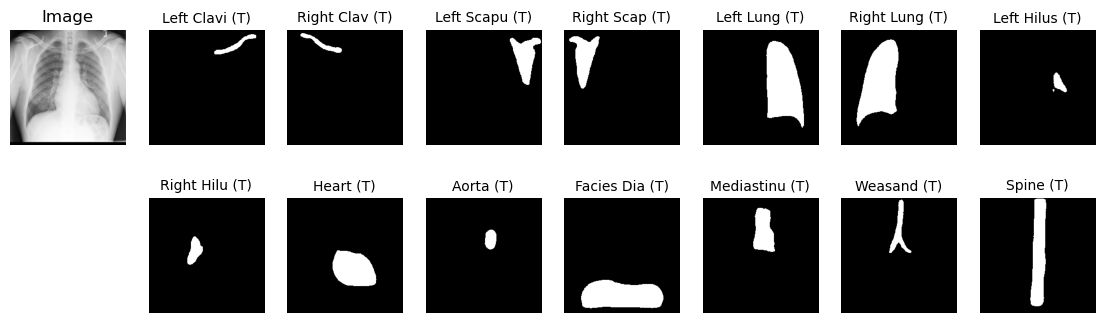

In [7]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"struct{i}" for i in range(7)]),
    (["."] + [f"struct{i}" for i in range(7,14)]),
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()

struct_titles = chestx_dataset.structure_names
ax["image"].imshow(chestx_image.numpy().transpose(1,2,0), cmap="gray")
ax["image"].set_title("Image")

for i in range(14):
    mask_t = chestx_structs[i].unsqueeze(0)
    ax[f"struct{i}"].imshow((mask_t.numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}"].set_title(f"{struct_titles[i][:10]} (T)", fontsize=10)

In [8]:
print(f"Pathologies present:")
for idx in chestx_pathols.nonzero():
    print("*", chestx_dataset.pathology_names[idx.item()])

Pathologies present:
* Cardiomegaly
* Infiltration


## Cosmological Mass Maps Dataset

This dataset contains clean simulated weak lensing maps without noise.
The relevant fields are as follows:
* `input`: A (1,66,66)-shaped weak lensing map
* `label`: A pair of numbers that represents the cosmological parameters Omega_m and sigma_8. In this dataset, the expert-specified features are absent.

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/massmaps-cosmogrid-100k).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/mass_maps.ipynb).

In [9]:
from exlib.datasets.mass_maps import MassMapsDataset
massmaps_dataset = MassMapsDataset(split="test")

Generating train split:   0%|          | 0/90000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

<Figure size 640x480 with 0 Axes>

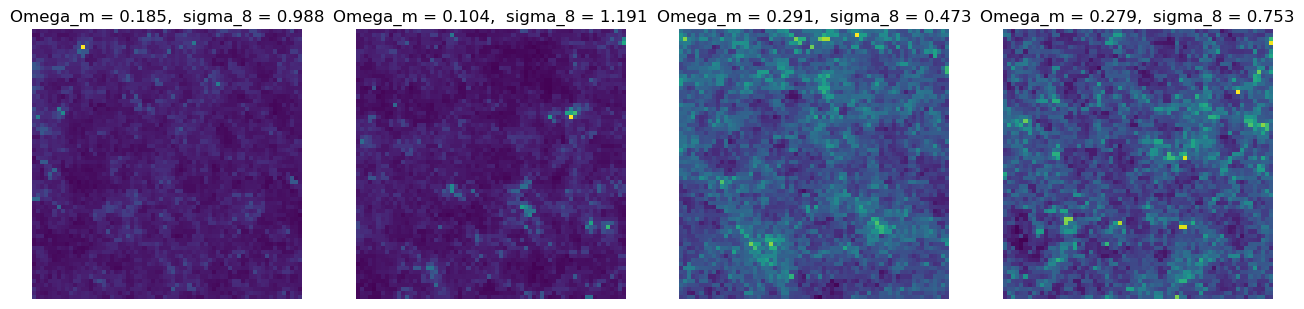

In [10]:
# Plot a few examples of mass maps
plt.clf()
fig, ax = plt.subplots(1,4, figsize=(16,4))
for i in range(len(ax)):
    mm_input = massmaps_dataset[i]["input"]
    mm_label = massmaps_dataset[i]["label"]
    ax[i].imshow(mm_input.numpy().transpose(1,2,0))
    ax[i].set_axis_off()
    ax[i].set_title(f"Omega_m = {mm_label[0]:.3f},  sigma_8 = {mm_label[1]:.3f}")   

## Emotion Dataset

This dataset contains 58k carefully curated Reddit comments labeled for 27 emotion categories or Neutral. The fields are as follows:
* `text`: The reddit comment.
* `labels`: The emotion annotations.
* `comment_id`: Unique identifier of the comment.

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/emotion).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/emotion.ipynb).

In [11]:
from exlib.datasets.emotion import EmotionDataset

emotion_dataset = EmotionDataset(split="test")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
from exlib.datasets.emotion import EmotionClassifier

emotion_dataloader = torch.utils.data.DataLoader(emotion_dataset, batch_size=4, shuffle=False)
emotion_model = EmotionClassifier().eval()

for batch in emotion_dataloader: 
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    output = emotion_model(input_ids, attention_mask)
    utterances = [
        emotion_dataset.tokenizer.decode(input_id, skip_special_tokens=True)
        for input_id in input_ids
    ]
    for utterance, label in zip(utterances, output.logits):
        id_str = emotion_model.model.config.id2label[label.argmax().item()]
        print("Text: {}\nEmotion: {}\n".format(utterance, id_str))
    break

SamLowe/roberta-base-go_emotions


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Text: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
Emotion: remorse

Text: It's wonderful because it's awful. At not with.
Emotion: admiration

Text: Kings fan here, good luck to you guys! Will be an interesting game to watch! 
Emotion: optimism

Text: I didn't know that, thank you for teaching me something today!
Emotion: gratitude



## Multilingual Politeness Dataset

This dataset contains conversation snippets from Wikipedia's editor talk pages. The fields are as follows:
* `text`: The Wikipedia's editor talk page conversation snippets.
* `politeness`: politeness level from -2 (very rude) to 2 (very polite).

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/multilingual_politeness).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/multilingual_politeness.ipynb).

In [13]:
from exlib.datasets.multilingual_politeness import PolitenessDataset
politeness_dataset = PolitenessDataset(split="test")

Generating train split:   0%|          | 0/18238 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2280 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2280 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [14]:
from exlib.datasets.multilingual_politeness import PolitenessClassifier

politeness_dataloader = torch.utils.data.DataLoader(politeness_dataset, batch_size=4, shuffle=False)
politeness_model = PolitenessClassifier().eval()

for batch in politeness_dataloader: 
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    output = politeness_model(input_ids, attention_mask)
    utterances = [
        politeness_dataset.tokenizer.decode(input_id, skip_special_tokens=True)
        for input_id in input_ids
    ]
    for utterance, label in zip(utterances, output):
        print("Text: {}\nPoliteness: {}\n".format(utterance, label.item()))
    break

config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at BrachioLab/xlm-roberta-politeness and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: The intro mentions the ISO 8601 international standard adopted in most western countries. What does this even mean? Who are we suggesting has done the adoption?
Politeness: 0.1725039780139923

Text: I'm a user on PrettyCure.org, and somebody on the site said they are making a fourth season of PreCure. It's a rumuor, but is it true? That person said it's more like Tokyo Mew Mew, a group of girls.
Politeness: -0.004305819049477577

Text: Hello fellow Wikipedians, I have just added archive links to on Essen. Please take a moment to review my edit. If necessary, add after the link to keep me from modifying it.
Politeness: 0.010885238647460938

Text: I saw the template citing this issue and since there was no section here discussing it I've decided to start one. I'm a Canadian and most of our television programs are also aired in the US so my knowledge of what's on TV outside of North America is limited. So I'm not sure of how much help I can be, but I do have some ideas on how to imp

## Supernova Dataset

This dataset contains astronomical time-series that has 18 types of astronomical sources. The fields are as follows:
* `label`: The class of the object.
* `times_wv`: 2D array of shape containing observation times (modified Julian days, MJD) and filter (wavelength) for each observation.
* `target`: 2D array of shape containing the flux (arbitrary units) and flux error for each observation.

You can access the dataset [here on Hugging Face](https://huggingface.co/datasets/BrachioLab/supernova-timeseries).
For more information, see this [notebook example](https://colab.research.google.com/github/BrachioLab/exlib/blob/main/notebooks/fix/supernova.ipynb).

In [15]:
from exlib.datasets.supernova import SupernovaDataset

supernova_dataset = SupernovaDataset(split="test")

Generating train split:   0%|          | 0/6274 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/782 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/792 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

In [16]:
supernova_item = supernova_dataset.dataset[0]
times_wv = torch.tensor(supernova_item["times_wv"])
xs = times_wv[:, 0]
ys = torch.tensor(supernova_item["target"])[:, 0]
times_wv, xs, ys = times_wv[ys!=0], xs[ys!=0], ys[ys!=0]
unique_wls = [3670.69, 4826.85, 6223.24, 7545.98, 8590.9, 9710.28]

<Figure size 640x480 with 0 Axes>

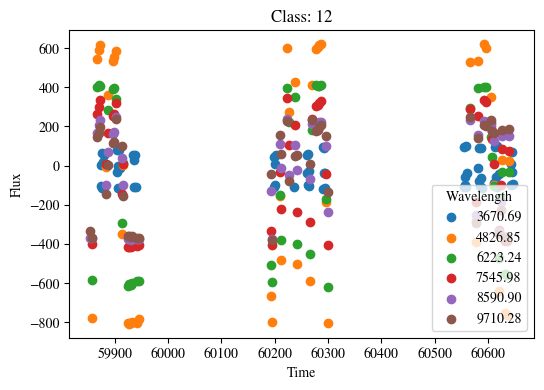

In [17]:
plt.clf()
plt.figure(figsize=(6,4))

for wl in unique_wls:
    mask = times_wv[:, 1] == wl
    plt.scatter(xs[mask], ys[mask], label=f'{wl:.2f}', cmap='viridis')

plt.title(f'Class: {supernova_item["label"]}')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(title='Wavelength')

# Part 2: Running benchmarks and evaluations

We now show how to run some benchmarks + evaluations.


## Vision Example (Cholecystectomy)

We show an example of groups generated by the quickshift segmentation algorithm compared to those that are labeled by our surgeon experts.

In [3]:
from exlib.datasets.cholec import CholecDataset, CholecFixScore
import exlib.features.vision as xfv
cholec_dataset = CholecDataset(split="test")
cholec_item = cholec_dataset[0]
cholec_image = cholec_item["image"]
cholec_organs = cholec_item["organs"]

quickshift_feature_extractor = xfv.QuickshiftGroups(max_groups=8)
quickshift_groups = quickshift_feature_extractor(cholec_image.unsqueeze(0))[0]

# Image, expert-specified groups, and quickshift-generated groups
cholec_image.shape, cholec_organs.shape, quickshift_groups.shape

(torch.Size([3, 360, 640]), torch.Size([360, 640]), torch.Size([8, 360, 640]))

Text(0.5, 1.0, 'Quickshift-generated groups')

<Figure size 640x480 with 0 Axes>

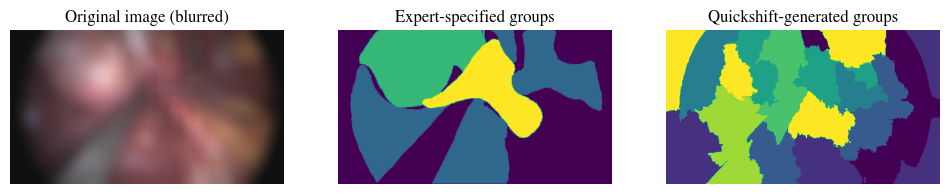

In [4]:
# Let's visualize these things
plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for a in ax: a.set_axis_off()

cholec_image = torchvision.transforms.GaussianBlur(41, (50.0, 50.0))(cholec_image)

ax[0].imshow(cholec_image.numpy().transpose(1,2,0))
ax[1].imshow(cholec_item["organs"].numpy())
ax[2].imshow((torch.arange(8).view(-1,1,1) * quickshift_groups).sum(dim=0).numpy())

ax[0].set_title("Original image (blurred)")
ax[1].set_title("Expert-specified groups")
ax[2].set_title("Quickshift-generated groups")

In [5]:
# Expects a pair of (N,C,H,W)-shaped things
cholec_metric = CholecFixScore()

# Adjust things to be able to be put into cholec_metric
cholec_organs_mask = F.one_hot(cholec_organs).permute(2,0,1).unsqueeze(0) # (1,num_true_groups,H,W)
batched_qs_groups = quickshift_groups.unsqueeze(0) # (1,num_pred_groups,H,W)

# The FIX score is computed for each pixel, and we just take the average
cholec_fix_score = cholec_metric(groups_pred=batched_qs_groups, groups_true=cholec_organs_mask)
print(cholec_fix_score.shape, cholec_fix_score.mean())

torch.Size([1]) tensor(0.1941)


## Natural Language Example (Multilingual Politeness)

We show an example of the groups demarcated at the sentence level.

In [6]:
from exlib.datasets.multilingual_politeness import PolitenessDataset
import exlib.features.text as xft
politeness_dataset = PolitenessDataset(split="test")
politeness_item = politeness_dataset[0]
politeness_word_list = [w for w in politeness_item["word_list"] if w.strip()]

sentence_feature_extractor = xft.SentenceGroups(distinct=26, scaling=1.5)
sentence_groups = sentence_feature_extractor(politeness_word_list)

In [7]:
print(" ".join(politeness_word_list), "\n")
for i, g in enumerate(sentence_groups):
    sentence = " ".join([politeness_word_list[ni.item()] for ni in g.nonzero()])
    print(f"Sentence {i+1}: {sentence}")

The intro mentions the ISO 8601 international standard adopted in most western countries. What does this even mean? Who are we suggesting has done the adoption? 

Sentence 1: Who are we suggesting has done the adoption?
Sentence 2: The intro mentions the ISO 8601 international standard adopted in most western countries.
Sentence 3: What does this even mean?


## Time-series Example (Supernova)

We show an example of groups based on slicing.

In [8]:
from exlib.datasets.supernova import SupernovaDataset, create_test_dataloader_raw
import exlib.features.time_series as xfts
supernova_dataset = SupernovaDataset(split="test")
supernova_item = supernova_dataset.dataset[0]
times_wv = torch.tensor(supernova_item["times_wv"])
xs = times_wv[:, 0]
ys = torch.tensor(supernova_item["target"])[:, 0]
times_wv, xs, ys = times_wv[ys!=0], xs[ys!=0], ys[ys!=0]
unique_wls = [3670.69, 4826.85, 6223.24, 7545.98, 8590.9, 9710.28]

slice_feature_extractor = xfts.SliceGroups(ngroups=10, window_size=100)

In [9]:
supernova_dataloader = create_test_dataloader_raw(
    dataset = supernova_dataset,
    batch_size = 5
)

for batch in supernova_dataloader:
    slice_groups = slice_feature_extractor(**batch)
    slice_groups = slice_groups[0]
    break

original dataset size: 792
remove nans dataset size: 792


<Figure size 640x480 with 0 Axes>

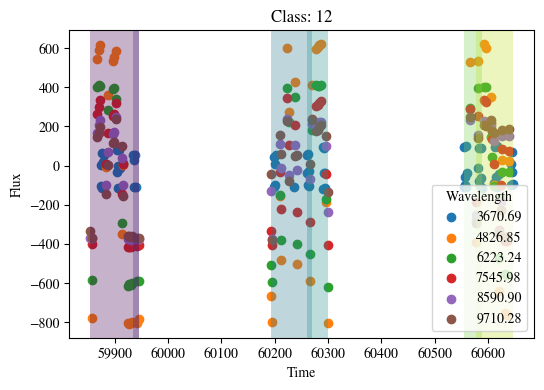

In [10]:
plt.clf()
plt.figure(figsize=(6,4))

# First plot the wavelengths like before
for wl in unique_wls:
    mask = times_wv[:, 1] == wl
    plt.scatter(xs[mask], ys[mask], label=f'{wl:.2f}', cmap="viridis")

# Then overlay the groups
cmap = plt.cm.get_cmap("viridis")
for i, g in enumerate(slice_groups):
    if g.sum() == 0: continue
    xmin = xs[g.nonzero().min().item()].item()
    xmax = xs[g.nonzero().max().item()].item()
    plt.axvspan(xmin, xmax, alpha=0.3, facecolor=cmap(i/len(slice_groups)))

plt.title(f'Class: {supernova_item["label"]}')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(title='Wavelength')

# Part 3: Get scores for a list of baselines

We now show how to get FixScore for a list of feature extractors for their corresponding datasets.
This part can be run standalone from the previous parts.

In [11]:
# !pip install exlib
import sys; sys.path.insert(0, "../src")
import exlib
import torch
import torch.nn.functional as F
import torchvision
import datasets as huggingface_datasets # Not to be confused with exlib.datasets!
import matplotlib.pyplot as plt
import numpy as np

In [20]:
import exlib.datasets as xd
import exlib.features.vision as xfv
import exlib.features.time_series as xfts
import exlib.features.text as xft
from datasets import load_dataset
from exlib.datasets.cholec import CholecDataset, CholecFixScore, preprocess_cholec
from exlib.datasets.chestx import ChestXDataset, ChestXFixScore, preprocess_chestx
from exlib.datasets.mass_maps import MassMapsDataset, MassMapsFixScore, preprocess_mass_maps
from exlib.datasets.supernova import SupernovaDataset, SupernovaFixScore, preprocess_supernova
from exlib.datasets.multilingual_politeness import PolitenessDataset, PolitenessFixScore, preprocess_politeness
from exlib.datasets.emotion import EmotionDataset, EmotionFixScore, preprocess_emotion

# there is a preprocess_xx in each folder
torch.manual_seed(1234)
l = [
    # dataset, feature_extractor, metric, preprocess
    (CholecDataset(split="test"), xfv.QuickshiftGroups(max_groups=8), CholecFixScore(), preprocess_cholec),
    (ChestXDataset(split="test"), xfv.QuickshiftGroups(max_groups=20), ChestXFixScore(), preprocess_chestx),
    (MassMapsDataset(split="test"), xfv.QuickshiftGroups(kernel_size=5, 
    max_dist=10, sigma=0.2, max_groups=25), MassMapsFixScore(), preprocess_mass_maps),
    (SupernovaDataset(split="test"), xfts.SliceGroups(ngroups=5, window_size=100), SupernovaFixScore(),
    preprocess_supernova),
    (PolitenessDataset(split="test"), 
     xft.WordGroups(distinct=26, scaling=1.5), PolitenessFixScore(),
    preprocess_politeness),
    (EmotionDataset(split="test"), 
     xft.WordGroups(distinct=4, scaling=1.5), EmotionFixScore(),
    preprocess_emotion)
]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

In [21]:
from collections import defaultdict
from torch.utils.data import Dataset, Subset, DataLoader
from tqdm.auto import tqdm

batch_size = 1
shuffle = True

device = "cuda" if torch.cuda.is_available() else "cpu"

all_scores = []

for dataset, feature_extractor, metric, preprocess in l:
    torch.manual_seed(1234)
    if hasattr(dataset, 'get_dataloader'): # if the dataset has its own dataloader, then use that
        dataloader = dataset.get_dataloader(batch_size=batch_size, shuffle=shuffle)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()
    
    scores = []
    for batch in tqdm(dataloader):
        # Preprocess the batch using the preprocess function for that dataset
        X, metric_inputs = preprocess(batch)
        # move inputs to device if they are tensors
        X = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in X.items()}
        metric_inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in metric_inputs.items()}
        
        # extract expert features
        expert_feats = feature_extractor(**X)
        # evaluate metric scores
        score = metric(expert_feats, **metric_inputs)
        
        if not isinstance(score, torch.Tensor):
            score = torch.tensor(score)
        scores.append(score)
        if len(scores) > 5: # comment out if evaluating on all the data
            break
    all_scores.append(torch.stack(scores).view(-1).tolist())

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/5774 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

original dataset size: 792
remove nans dataset size: 792


  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [22]:
all_scores

[[0.3367127776145935,
  0.24618272483348846,
  0.22098955512046814,
  0.2326677143573761,
  0.2342454046010971,
  0.2688691020011902],
 [0.35147568583488464,
  0.364093154668808,
  0.3598777651786804,
  0.29281893372535706,
  0.311981737613678,
  0.5429286956787109],
 [0.5598839521408081,
  0.4669473469257355,
  0.5471238493919373,
  0.5848723649978638,
  0.7525796890258789,
  0.6645547151565552],
 [0.0, 0.14010204374790192, 0.16688647866249084, 0.0, 0.0, 0.0],
 [0.8011213541030884,
  0.47968652844429016,
  0.6839905977249146,
  0.7663680911064148,
  0.7839836478233337,
  0.8409663438796997],
 [0.14496539594075863,
  0.12556647487263883,
  0.09690698389622354,
  0.09637252818061626,
  0.14496539594075863,
  0.135084007683278]]

In [23]:
# get mean and std of each baseline

import numpy as np
from exlib.utils import bootstrap

for i in range(len(all_scores)):
    print(i, np.mean(all_scores[i]), bootstrap(torch.tensor(all_scores[i])).item())

0 0.2566112130880356 0.012027651071548462
1 0.37052932878335315 0.03009992279112339
2 0.5959936529397964 0.010402358137071133
3 0.05116475373506546 0.012833249755203724
4 0.7260194271802902 0.03134259581565857
5 0.12397679775237898 0.0066144149750471115
